# ISLP - Chapter 12 - Exercise 11
### Author: pzuehlke

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Connection with the SVD

Step (a) can be solved using Singular Value Decomposition (SVD), as we now explain.

First, we can rewrite this minimization problem in matrix form as:
  $$
    \underset{\mathbf{A},\ \mathbf{B}}{\text{minimize}}
    \|\widetilde{\mathbf{X}} - \mathbf{A}\mathbf{B}^T\|_F^2
  $$
  where $ \|\cdot\|_F $ is the Frobenius norm (i.e., the square root of the sum
  of squares of all the entries).

Now the SVD of $ \widetilde{\mathbf{X}} $ gives us
$ \widetilde{\mathbf{X}} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T $
where:
  * $ \mathbf{U} $ is an $ n \times n $ orthogonal matrix containing the left
    singular vectors.
  * $ \mathbf{\Sigma} $ is an $ n \times p $ diagonal matrix of singular values
    (arranged in descending order).
  * $ \mathbf{V} $ is a $ p \times p $ orthogonal matrix containing the right
    singular vectors.

The Eckart-Young theorem states that the best rank-$ M $ approximation of
$ \widetilde{\mathbf{X}} $ is:
$$
  \widetilde{\mathbf{X}}_M = \mathbf{U}_M\mathbf{\Sigma}_M\mathbf{V}_M^T
$$
where:
* $ \mathbf{U}_M $ contains the first $ M $ columns of $ \mathbf{U} $.
* $ \mathbf{\Sigma}_M $ is the upper-left $ M \times M $ submatrix of $
  \mathbf{\Sigma} $.
* $ \mathbf{V}_M $ contains the first $ M $ columns of $ \mathbf{V} $; equivalently,
  $ \mathbf{V}_M^T $ contains the first $ M $ lines of $ \mathbf{V}^T $.

Thus, we can minimize the objective function by setting
$$
  \mathbf{A} = \mathbf{U}_M\mathbf{\Sigma}_M^{1/2} \quad \text{and} \quad
  \mathbf{B} = \mathbf{V}_M\mathbf{\Sigma}_M^{1/2}\,.
$$
Then in step (b) we update the values of $ \widetilde{\mathbf{X}} $ whose
indices do not lie in $ \mathcal{O} $ with the corresponding ones of
$ \mathbf{A} \mathbf{B}^T $ and iterate.

Now let's implement Algorithm $ 2.1 $ with the help of the SVD in the following
procedure:

In [10]:
def matrix_completion(X, M=1, max_iter=100, threshold=1e-7, verbose=False):
    """
    Perform matrix completion using Algorithm 12.1 and SVD.
    
    Parameters:
    -----------
    X : numpy array
        The data matrix with missing values (np.nan).
    M : int
        Number of components to use in the low-rank approximation.
    max_iter : int
        Maximum number of iterations.
    threshold : float
        Convergence threshold for _relative_ error.
    verbose : bool
        Whether to print progress in each iteration.
    
    Returns:
    X_hat : numpy array
        The completed matrix.
    iterations : int
        Number of iterations performed.
    rel_errors : list
        Relative errors at each iteration.
    """
    # Step 1: Initialize X_hat by replacing missing values with column means:
    is_missing = np.isnan(X)
    X_hat = X.copy()  # will hold the final result
    X_bar = np.nanmean(X_hat, axis=0)
    # Replace missing values with column means:
    for j in range(X.shape[1]):
        X_hat[is_missing[:, j], j] = X_bar[j]
    # Setup for tracking progress:
    rel_err = 1
    count = 0
    rel_errors = []
    # Compute initial MSE of non-missing elements:
    mse_0 = np.mean(X[~is_missing]**2)
    mse_old = mse_0
    
    # Step 2: Perform iterative algorithm:
    while rel_err > threshold and count < max_iter:
        count += 1
        # Step 2(a): Low-rank approximation of X_hat:
        U, D, Vt = np.linalg.svd(X_hat, full_matrices=False)
        X_approx = U[:, :M] @ np.diag(D[:M]) @ Vt[:M, :]
        # Step 2(b): Update X_hat using X_approx only for missing entries:
        X_hat[is_missing] = X_approx[is_missing]
        # Step 2(c): Compute new relative error:
        mse = np.mean(((X - X_approx)[~is_missing])**2)
        rel_err = (mse_old - mse) / mse_0
        mse_old = mse
        rel_errors.append(rel_err)
        if verbose:
            print(f"Iteration: {count}, MSE: {mse:.3f}, relative error: {rel_err:.2e}")
    
    return X_hat, count, rel_errors

Since we will have to perform matrix completion for several values of $ M $ and
several proportions of missing observations, we will encapsulate this work in
another procedure. Recall that the sets of missing observations must be nested
as the missing percentage increases, for each repetition series.

In [ ]:
def run_experiment(X, missing_percentages, M_values, repetitions=10):
    """
    Run matrix completion experiments with varying percentages of missing values
    and different M values.
    
    Parameters:
    -----------
    X : numpy array
        The data matrix.
    missing_percentages : list
        Percentages of missing values.
    M_values : list
        Values of M to try.
    repetitions : int
        Number of repetitions for each experiment.
    
    Returns:
    --------
    results : numpy array
        Average approximation errors.
    """
    rng = np.random.RandomState(1)
    n, p = X.shape
    results = np.zeros((len(missing_percentages), len(M_values)))
    
    for rep in range(repetitions):
        # Generate all potentially missing indices for this repetition series 
        # at once. As the percentage increases, the missing observations will
        # be subsets of this maximal set:
        max_missing = int(n * p * missing_percentages[-1])
        all_possible_missing_indices = rng.choice(
            n * p, max_missing, replace=False
        )
        
        for i, missing_pct in enumerate(missing_percentages):
            # Take appropriate subset of indices for current percentage:
            n_missing = int(n * p * missing_pct)
            current_missing_indices = all_possible_missing_indices[:n_missing]
            # Convert to row, col format:
            row_idx, col_idx = np.unravel_index(current_missing_indices, (n, p))
            
            for j, M in enumerate(M_values):
                # Create copy and set missing values:
                X_missing = X.copy()
                X_missing[row_idx, col_idx] = np.nan

                X_completed, _, _ = matrix_completion(X_missing, M=M)

                error = np.mean(((X - X_completed)[row_idx, col_idx])**2)

                results[i, j] += error / repetitions
    
    return results

Let's run the experiment on the Boston dataset for $ M = 1,\,2, \cdots, 8 $
and missing percentages $ 5\%,\,10\%, \cdots, 30\% $. This cell takes about $ 5s
$ to run on my machine.

In [27]:
boston = pd.read_csv("Boston.csv")

scaler = StandardScaler()
boston_scaled = scaler.fit_transform(boston)

# Run experiment:
missing_percentages = np.arange(0.05, 0.35, 0.05)
M_values = range(1, 9)
results = run_experiment(boston_scaled, missing_percentages, M_values)


Now let's plot the results of the experiment:

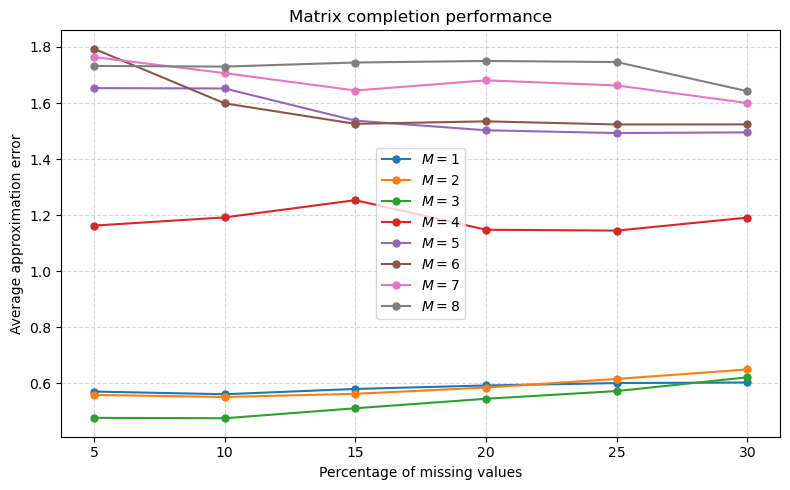

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
for j, M in enumerate(M_values):
    ax.plot(missing_percentages * 100, results[:, j],
            'o-', label=f"$ M = {M} $", ms=5)
ax.set_xlabel("Percentage of missing values")
ax.set_ylabel("Average approximation error")
ax.set_title("Matrix completion performance")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()
plt.show()

We can see that the best results are obtained for $ M = 1,\,2 $ and $ 3 $
principal components.  In theory, using more principal components should capture
more information from the data, but our results suggest that higher values of $
M $ lead to overfitting. This is also supported by the fact that even though the
mean errors increase with the percentage of missing values for low values of $ M
$, this is not the case for $ M > 4 $. It seems that the missing values act as a
form of regularization that balances the overfitting for large $ M $.